# Исследование объявлений о продаже квартир

В вашем распоряжении данные сервиса Яндекс.Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктов за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Ваша задача — установить параметры. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

### Откройте файл с данными и изучите общую информацию. 

Строк, столбцов: (23699, 22)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   total_images          23699 non-null  int64  
 1   last_price            23699 non-null  float64
 2   total_area            23699 non-null  float64
 3   first_day_exposition  23699 non-null  object 
 4   rooms                 23699 non-null  int64  
 5   ceiling_height        14504 non-null  float64
 6   floors_total          23613 non-null  float64
 7   living_area           21796 non-null  float64
 8   floor                 23699 non-null  int64  
 9   is_apartment          2775 non-null   object 
 10  studio                23699 non-null  bool   
 11  open_plan             23699 non-null  bool   
 12  kitchen_area          21421 non-null  float64
 13  balcony               12180 non-null  float64
 14  locality_name         23650 non-null  obj

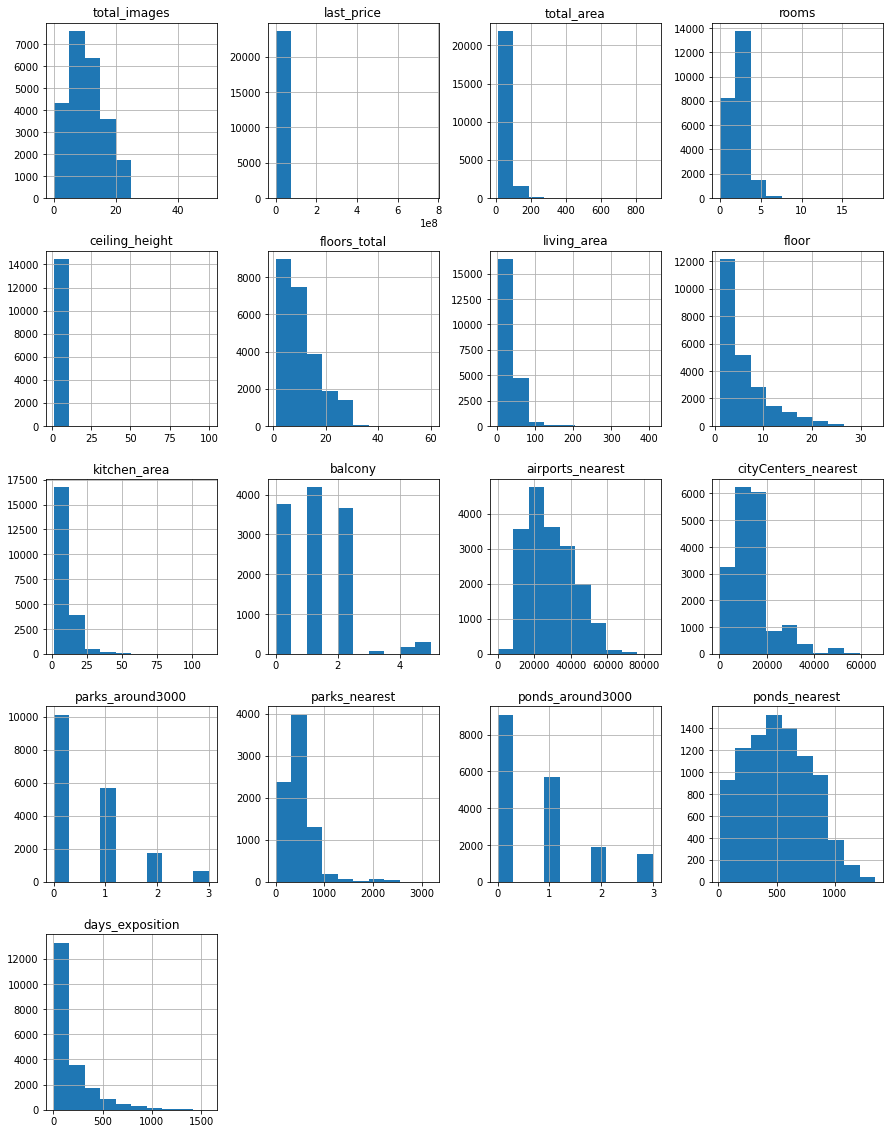

In [142]:
import pandas as pd
from numpy import nan
import matplotlib.pyplot as plt
try:
    data = pd.read_csv('/real_estate_data.csv', sep="\t");
except:
    data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t')
pd.set_option('max_columns', 30)
print('Строк, столбцов:', data.shape)
print(data.info())
data.hist(figsize=(15,20))
plt.show();

In [143]:
# Cмотрим есть ли повторы в таблице

print(data.duplicated().sum())

0


### Предобработка данных

In [144]:
print(data.columns[data.isna().any() == True])
#pd.DataFrame(round(data.isna().mean()*100,)).style.background_gradient('coolwarm') # смотрим в каких столбцах есть пропущенные значения.

Index(['ceiling_height', 'floors_total', 'living_area', 'is_apartment',
       'kitchen_area', 'balcony', 'locality_name', 'airports_nearest',
       'cityCenters_nearest', 'parks_around3000', 'parks_nearest',
       'ponds_around3000', 'ponds_nearest', 'days_exposition'],
      dtype='object')


>Столбец ['locality_name'] также содержит пропуски, но логичной замены не найти, назовем их unknown.
Пропуски в столбце ['balcony'] c скорее всего связаны с отсутствием балконов в квартире. Заменяем на **0**

In [145]:
data['locality_name'] = data['locality_name'].fillna('unknown')

# Заполняем значения медианой где это допустимо 
data['ceiling_height'] = data['ceiling_height'].fillna(data['ceiling_height'].median()) # данные еще с аномальными значениями, заполняем пропуски медианныи значениями
data.loc[(data['floor'] > 0), 'floors_total'] = data['floors_total'].fillna(data['floors_total'].median()) # прадварительно проверив есть ли указан ли вообще этаж у таких строк, заполняем пропуски медианныи значениями
data['living_area'] = data['living_area'].fillna(data['living_area'].median())
data['kitchen_area'] = data['kitchen_area'].fillna(data['kitchen_area'].median())
data['airports_nearest'] = data['airports_nearest'].fillna(data['airports_nearest'].median())
data['cityCenters_nearest'] = data['cityCenters_nearest'].fillna(data['cityCenters_nearest'].median())
data['days_exposition'] = data['days_exposition'].fillna(data['days_exposition'].median())

#Далее заполняем пропуски в столбцах, в которых может наблюдаться зависимость друг от друга
data.loc[(data['parks_nearest'] > 3000) & (data['parks_around3000'].isna()), 'parks_around3000'] = 0 # записываем 0 в кол-во парков в радиусе 3000, если в столбце parks_nearest значение больше 3000
data['parks_around3000'] = data['parks_around3000'].fillna(data['parks_around3000'].median()) # записываем медианными значениями оставшиеся 
data.loc[(data['ponds_nearest'] > 3000) & (data['ponds_around3000'].isna()), 'ponds_around3000'] = 0 # записываем 0 в кол-во водоемов в радиусе 3000, если в столбце ponds_nearest значение больше 3000
data['ponds_around3000'] = data['ponds_around3000'].fillna(data['ponds_around3000'].median()) # записываем медианными значениями оставшиеся

# Пропуски в столбце ['balcony'] c скорее всего связаны с отсутствием балконов в квартире. Заменяем на 0
data['balcony'] = data['balcony'].fillna(0)

# ['is_apartment'] содержит булевые значения, предположим их отсутствие означает, что это не аппартаменты
data['is_apartment'] = data['is_apartment'].fillna(False)

>Рассмотрим типы данных в каждом столбце:



In [146]:
data.dtypes

total_images              int64
last_price              float64
total_area              float64
first_day_exposition     object
rooms                     int64
ceiling_height          float64
floors_total            float64
living_area             float64
floor                     int64
is_apartment               bool
studio                     bool
open_plan                  bool
kitchen_area            float64
balcony                 float64
locality_name            object
airports_nearest        float64
cityCenters_nearest     float64
parks_around3000        float64
parks_nearest           float64
ponds_around3000        float64
ponds_nearest           float64
days_exposition         float64
dtype: object

>Отметим, что не все стобцы содержат подходящий или желательный их значениям тип данных, а именно:

1.   **first_day_exposition** - имеет тип object, исправим на datetime
2.   **floors_total** - имеет тип float64, исправим на int64
3.   **balcony** - имеет тип float64, исправим на int64
4.   **days_exposition** - имеет тип float64, исправим на int64
5.   **parks_around3000** и **ponds_around3000** - также исправим на int64 т.к. в этих столбцах всегда будет целое число



In [147]:
data['first_day_exposition'] = pd.to_datetime(data['first_day_exposition']) # отформатируем с форматом по умолчанию, т.к. сохранять время нам не нужно
data['floors_total'] = data['floors_total'].astype('int64')
data['balcony'] = data['balcony'].astype('int64')
data['days_exposition'] = data['days_exposition'].astype('int64')
data['ponds_around3000'] = data['ponds_around3000'].astype('int64')
data['parks_around3000'] = data['parks_around3000'].astype('int64')
data.dtypes

total_images                     int64
last_price                     float64
total_area                     float64
first_day_exposition    datetime64[ns]
rooms                            int64
ceiling_height                 float64
floors_total                     int64
living_area                    float64
floor                            int64
is_apartment                      bool
studio                            bool
open_plan                         bool
kitchen_area                   float64
balcony                          int64
locality_name                   object
airports_nearest               float64
cityCenters_nearest            float64
parks_around3000                 int64
parks_nearest                  float64
ponds_around3000                 int64
ponds_nearest                  float64
days_exposition                  int64
dtype: object

Теперь тип данных имееет корретную форму. Это было необходимо для удобства чтания и работы с данными, а также для предотвращения возникновения непредвиденных ошибок.

>Изучите уникальные значения в столбце с названиями и устраните неявные дубликаты. Например, «поселок Рябово» и «поселок городского типа Рябово», «поселок Тельмана» и «посёлок Тельмана» — это обозначения одних и тех же населённых пунктов. 

In [148]:
# Убираем различия в слове посёлок
data['locality_name'] = data['locality_name'].str.replace("поселок", "посёлок") 

# Приравняем разные типы посёлков к одному, для удобства подсчета
poselki = {'городской посёлок' : 'посёлок', 
       'посёлок городского типа' : 'посёлок',   
       'коттеджный посёлок' : 'посёлок', 
       'садоводческое некоммерческое товарищество' : 'садовое товарищество', 
       'посёлок станции' : 'посёлок',
       'посёлок при железнодорожной станции' : 'посёлок'}

# Заменяем, применяя новый словарь
data['locality_name'] = data['locality_name'].replace(poselki, regex=True)

# Проверяем
print(data['locality_name'].unique())

['Санкт-Петербург' 'посёлок Шушары' 'посёлок Янино-1' 'посёлок Парголово'
 'посёлок Мурино' 'Ломоносов' 'Сертолово' 'Петергоф' 'Пушкин'
 'деревня Кудрово' 'Коммунар' 'Колпино' 'посёлок Красный Бор' 'Гатчина'
 'деревня Фёдоровское' 'Выборг' 'Кронштадт' 'Кировск'
 'деревня Новое Девяткино' 'посёлок Металлострой' 'посёлок Лебяжье'
 'посёлок Сиверский' 'посёлок Молодцово' 'посёлок Кузьмоловский'
 'садовое товарищество Новая Ропша' 'Павловск' 'деревня Пикколово'
 'Всеволожск' 'Волхов' 'Кингисепп' 'Приозерск' 'Сестрорецк'
 'деревня Куттузи' 'посёлок Аннино' 'посёлок Ефимовский'
 'посёлок Плодовое' 'деревня Заклинье' 'посёлок Торковичи'
 'посёлок Первомайское' 'Красное Село' 'посёлок Понтонный' 'Сясьстрой'
 'деревня Старая' 'деревня Лесколово' 'посёлок Новый Свет' 'Сланцы'
 'село Путилово' 'Ивангород' 'Мурино' 'Шлиссельбург' 'Никольское'
 'Зеленогорск' 'Сосновый Бор' 'деревня Оржицы' 'деревня Кальтино'
 'Кудрово' 'посёлок Романовка' 'посёлок Бугры' 'посёлок Рощино' 'Кириши'
 'Луга' 'Волосово'

#Шаг 2. Предобработка данных

>Найдите и устраните редкие и выбивающиеся значения. Например, в столбце ceiling_height может быть указана высота потолков 25 м и 32 м. Логично предположить, что на самом деле это вещественные значения: 2.5 м и 3.2 м. Попробуйте обработать аномалии в этом и других столбцах.
 
>Если природа аномалии понятна и данные действительно искажены, то восстановите корректное значение.
В противном случае удалите редкие и выбивающиеся значения.
В ячейке с типом markdown опишите, какие особенности в данных вы обнаружили.

In [149]:
# Устраним аномалию с нереалистичной высото потолков
data.loc[data['ceiling_height'] > 10, 'ceiling_height'] /= 10 

# В столбце ['rooms'] имеются строки со значением 0, будем считать это за одну комнату
data.loc[data['rooms'] == 0, 'rooms'] = 1

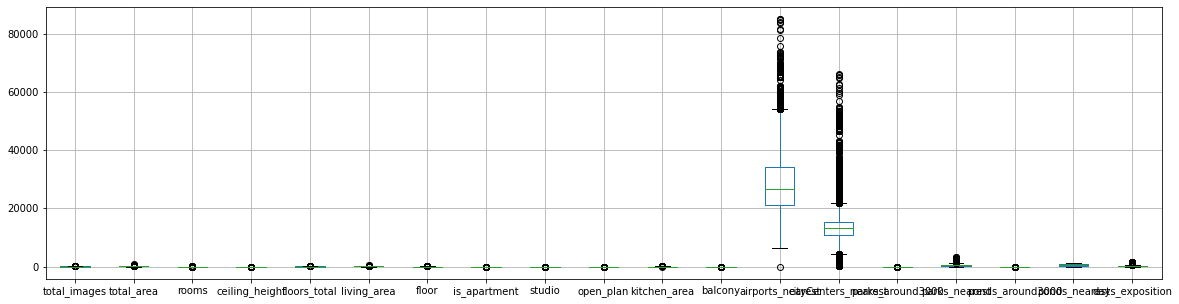

In [150]:
#data.boxplot(figsize=(20,5))
data.loc[:, data.columns != 'last_price'].boxplot(figsize=(20,5))
plt.show();

Столбец total_images


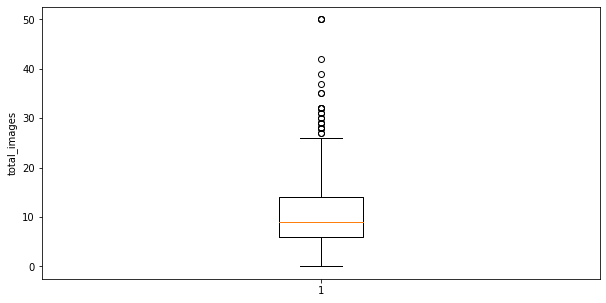

Столбец last_price


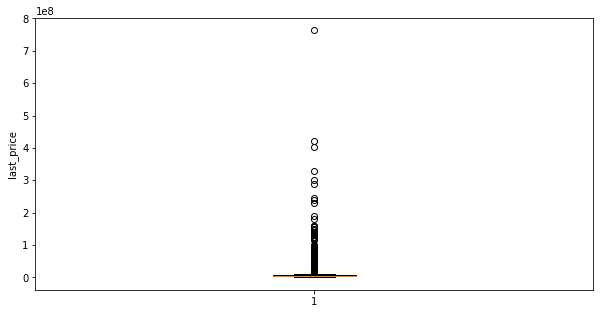

Столбец total_area


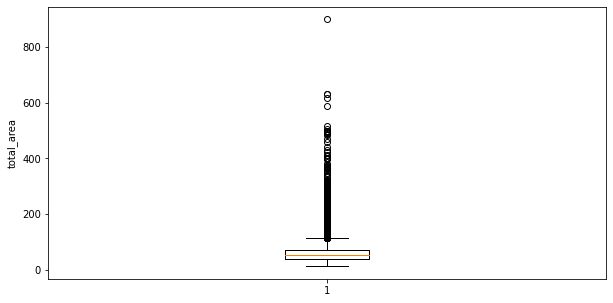

Столбец first_day_exposition
Для first_day_exposition нельзя!
Столбец rooms


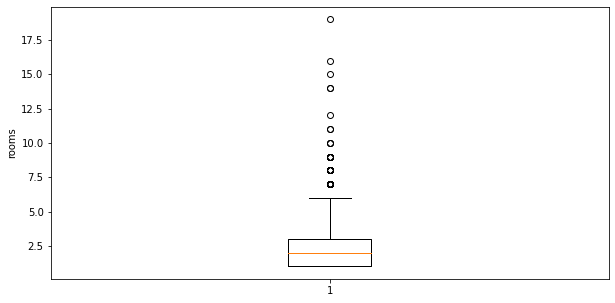

Столбец ceiling_height


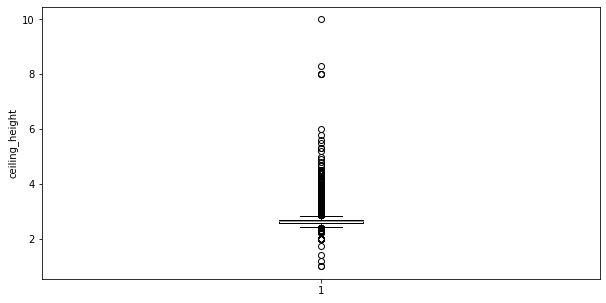

Столбец floors_total


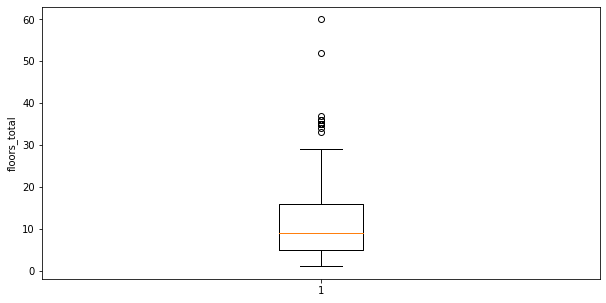

Столбец living_area


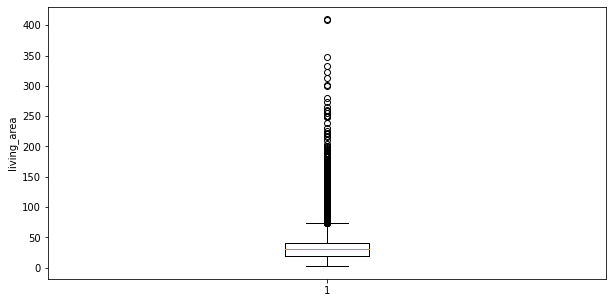

Столбец floor


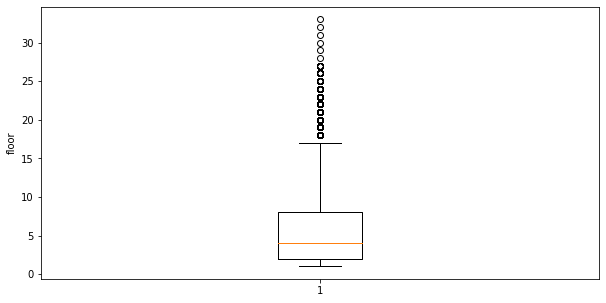

Столбец is_apartment
Для is_apartment нельзя!
Столбец studio
Для studio нельзя!
Столбец open_plan
Для open_plan нельзя!
Столбец kitchen_area


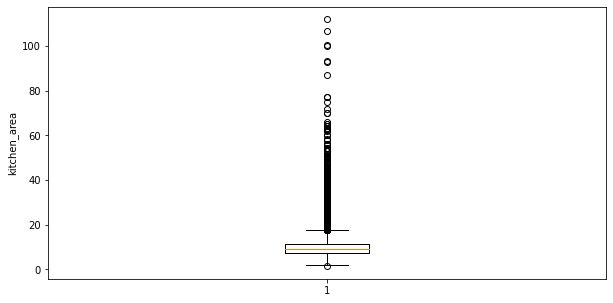

Столбец balcony


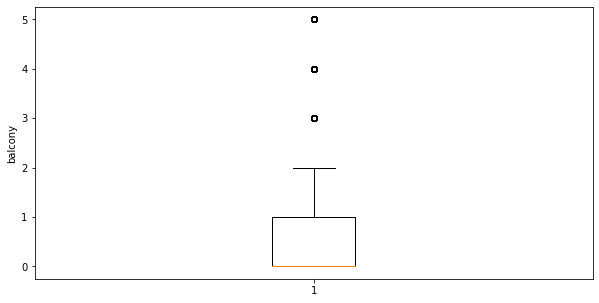

Столбец locality_name
Для locality_name нельзя!
Столбец airports_nearest


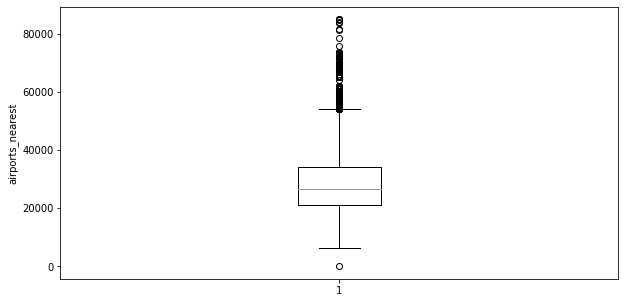

Столбец cityCenters_nearest


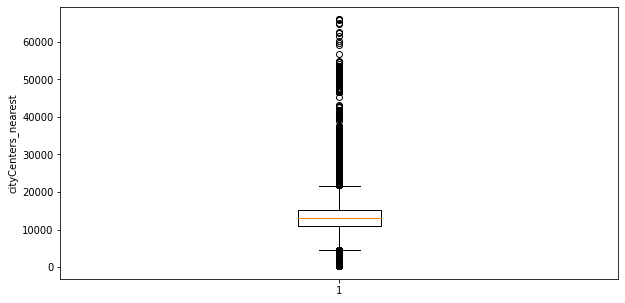

Столбец parks_around3000


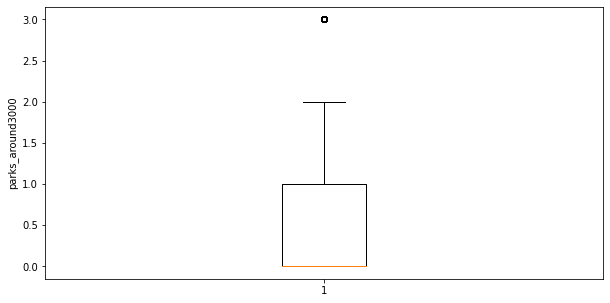

Столбец parks_nearest


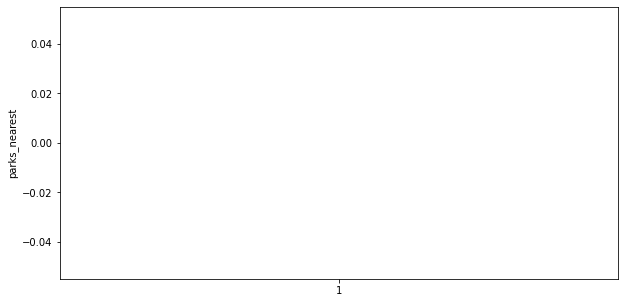

Столбец ponds_around3000


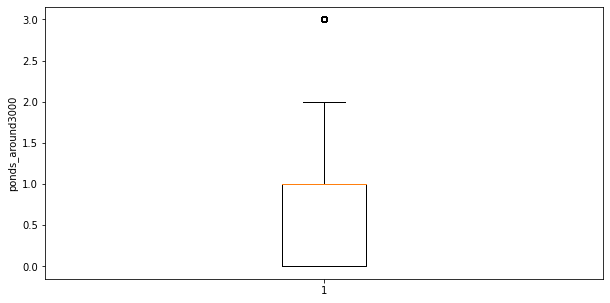

Столбец ponds_nearest


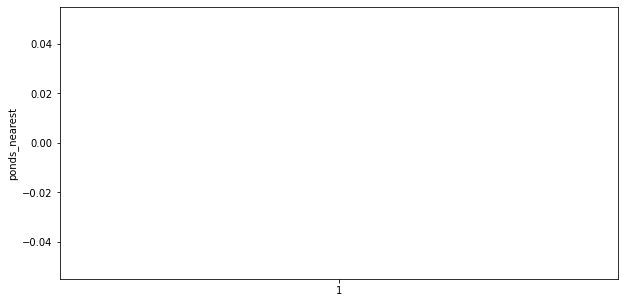

Столбец days_exposition


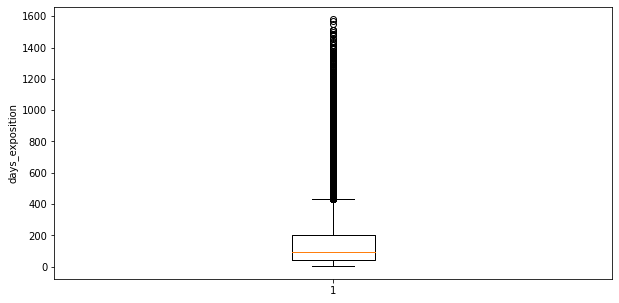

In [151]:
for col in data:
    try:
        print('Столбец', col)
        plt.boxplot(data[col]);
        plt.ylabel(col)
        plt.show();
    except:
        print('Для', col, 'нельзя!' )

In [152]:
print(data['last_price'].describe())


print(data['airports_nearest'].describe())

data['cityCenters_nearest'].describe()

count    2.369900e+04
mean     6.541549e+06
std      1.088701e+07
min      1.219000e+04
25%      3.400000e+06
50%      4.650000e+06
75%      6.800000e+06
max      7.630000e+08
Name: last_price, dtype: float64
count    23699.000000
mean     28310.148023
std      11090.330161
min          0.000000
25%      21183.000000
50%      26726.000000
75%      34327.000000
max      84869.000000
Name: airports_nearest, dtype: float64


count    23699.000000
mean     13936.792797
std       7553.779633
min        181.000000
25%      10927.000000
50%      13098.500000
75%      15248.500000
max      65968.000000
Name: cityCenters_nearest, dtype: float64

**Как видно выбросы есть в 3 столбцах: last_price, airports_nearest, cityCenters_nearest. Но данные не похоже на ошибочно введенные и соответствуют реальным объектам, удалять их не станем.**

#Шаг 3. Посчитайте и добавьте в таблицу новые столбцы

>Добавьте в таблицу новые столбцы со следующими параметрами:
1.   Цена одного квадратного метра;
2.   день недели публикации объявления (0 — понедельник, 1 — вторник и так далее);
3.   Месяц публикации объявления;
4.   Год публикации объявления;
5.   Тип этажа квартиры (значения — «‎первый», «последний», «другой»);
6.   Расстояние до центра города в километрах (переведите из м в км и округлите до целых значений).


In [153]:
# Столбец с ценой квадратного метра
data['meter_price'] = (data['last_price'] / data['total_area']).round(2)
 
# Столбец с Днем недели публикации 1-7 (Пн-Вс)
data['day'] = data['first_day_exposition'].dt.weekday +1

# Месяц публикации
data['month'] = data['first_day_exposition'].dt.month

# Год публикации
data['year'] = data['first_day_exposition'].dt.year

# Тип этажа (Первый\Последний\ Другой)
data.loc[data['floor'] == data['floors_total'], 'floor_type'] = 'Последний'
data.loc[data['floor'] == 1, 'floor_type'] = 'Первый'
data.loc[(data['floor'] != data['floors_total']) & (data['floor'] != data['floor'].min() ), 'floor_type'] = 'Другой'

# Перевети расстояние до центра города из м в км и округлиь до цеых)
data['cityCenters_nearest'] = (data['cityCenters_nearest'] / 1000).round(0)

### Шаг 4. Проведите исследовательский анализ данных:


>Изучите следующие параметры объектов:
общая площадь;
жилая площадь;
площадь кухни;
цена объекта;
количество комнат;
высота потолков;
этаж квартиры;
тип этажа квартиры («первый», «последний», «другой»);
общее количество этажей в доме;
расстояние до центра города в метрах;
расстояние до ближайшего аэропорта;
расстояние до ближайшего парка;
день и месяц публикации объявления.
Постройте отдельные гистограммы для каждого из этих параметров. Опишите все ваши наблюдения по параметрам в ячейке с типом markdown.
Изучите, как быстро продавались квартиры (столбец days_exposition). Этот параметр показывает, сколько дней было размещено каждое объявление. 
Изучите следующие параметры объектов:
общая площадь;
жилая площадь;
площадь кухни;
цена объекта;
количество комнат;
высота потолков;
этаж квартиры;
тип этажа квартиры («первый», «последний», «другой»);
общее количество этажей в доме;
расстояние до центра города в метрах;
расстояние до ближайшего аэропорта;
расстояние до ближайшего парка;
день и месяц публикации объявления.


In [154]:
display(data[['total_area', 'living_area', 'kitchen_area','last_price', 'rooms', 'ceiling_height', 'floor', 'floor_type', 'floors_total', 'cityCenters_nearest', 'airports_nearest', 'parks_nearest', 'first_day_exposition', 'day', 'month']].describe().round(1))

,total_area,living_area,kitchen_area,last_price,rooms,ceiling_height,floor,floors_total,cityCenters_nearest,airports_nearest,parks_nearest,day,month
count,23699.0,23699.0,23699.0,23699.0,23699.0,23699.0,23699.0,23699.0,23699.0,23699.0,8079.0,23699.0,23699.0
mean,60.3,34.1,10.4,6541548.8,2.1,2.7,5.9,10.7,13.9,28310.1,490.8,3.6,6.4
std,35.7,21.2,5.6,10887013.3,1.1,0.2,4.9,6.6,7.6,11090.3,342.3,1.8,3.5
min,12.0,2.0,1.3,12190.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0
25%,40.0,19.0,7.4,3400000.0,1.0,2.6,2.0,5.0,11.0,21183.0,288.0,2.0,3.0
50%,52.0,30.0,9.1,4650000.0,2.0,2.6,4.0,9.0,13.0,26726.0,455.0,4.0,6.0
75%,69.9,41.1,11.4,6800000.0,3.0,2.7,8.0,16.0,15.0,34327.0,612.0,5.0,10.0
max,900.0,409.7,112.0,763000000.0,19.0,10.0,33.0,60.0,66.0,84869.0,3190.0,7.0,12.0


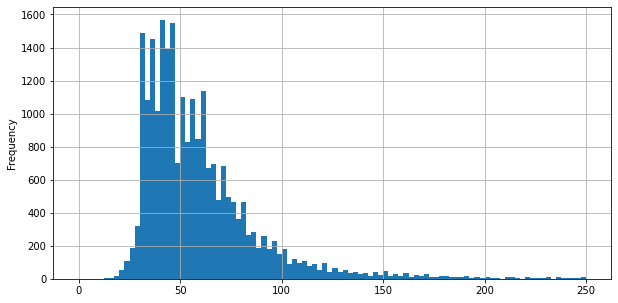

In [155]:
data['total_area'].plot(kind='hist', bins=100, range=[0, 250], figsize=(10,5), grid=True, xlabel='Площадь', ylabel='Кол-во квартир')
plt.show()

**Больше всего квартир с общей площадью 30 и 40 квадратных метров**



count    23699.000000
mean        34.099892
std         21.162096
min          2.000000
25%         19.000000
50%         30.000000
75%         41.100000
max        409.700000
Name: living_area, dtype: float64

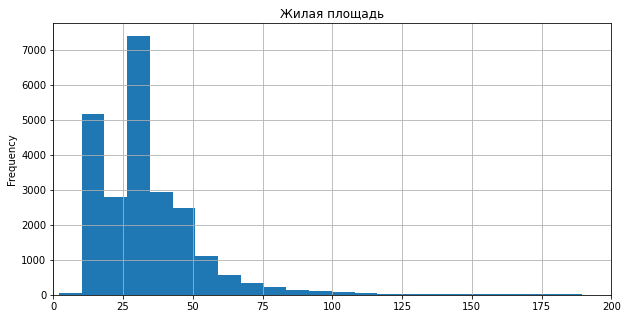

In [156]:
display(data['living_area'].describe())
data['living_area'].plot(kind = 'hist', bins = 50,figsize = (10,5), grid = True, xlim = (0,200), title='Жилая площадь')
plt.show();

**Распространены квартиры с жилой площадью от 15 до 30 квадратных метров**

> Блок с отступами





count    23699.000000
mean        10.428526
std          5.631126
min          1.300000
25%          7.400000
50%          9.100000
75%         11.440000
max        112.000000
Name: kitchen_area, dtype: float64

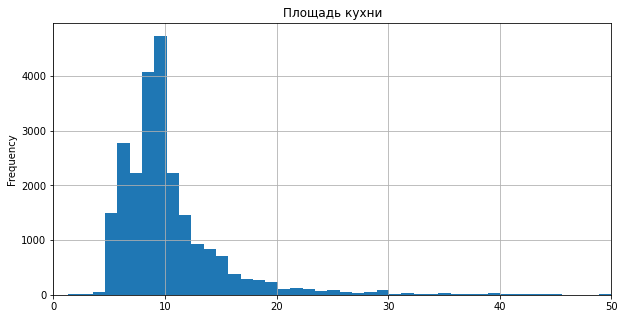

In [157]:
display(data['kitchen_area'].describe())
data['kitchen_area'].plot(kind = 'hist', bins = 100,figsize = (10,5), grid = True, xlim = (0,50), title='Площадь кухни')
plt.show();

**Самая распространенная площадь кухни от 5 до 10 кв. метров**



count    2.369900e+04
mean     6.541549e+06
std      1.088701e+07
min      1.219000e+04
25%      3.400000e+06
50%      4.650000e+06
75%      6.800000e+06
max      7.630000e+08
Name: last_price, dtype: float64

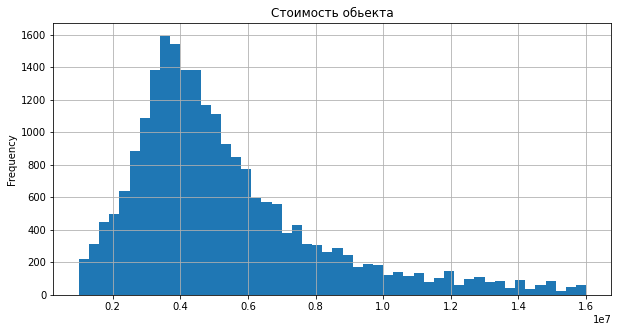

In [158]:
display(data['last_price'].describe())
data['last_price'].plot(kind='hist', bins=50, range=(1000000,16000000), grid=True, title='Стоимость обьекта')
plt.show();

**Чаще всего квартиры продаются по цене около 4 млн. рублей, далеее наблюдается тенденция к снижению кол-ва предложения по отношению к росту цены**

count    23699.000000
mean         2.078948
std          1.066196
min          1.000000
25%          1.000000
50%          2.000000
75%          3.000000
max         19.000000
Name: rooms, dtype: float64

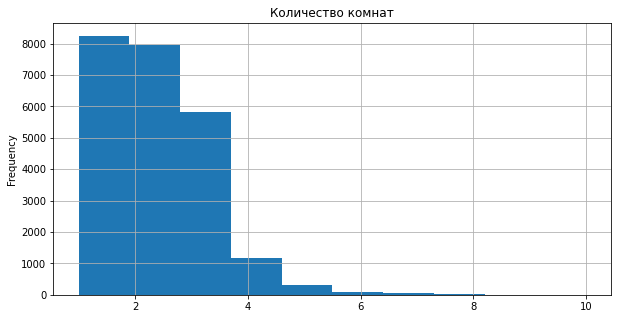

In [159]:
display(data['rooms'].describe())
data['rooms'].plot(kind='hist', bins=10, range=(1,10), grid=True, title='Количество комнат')
plt.show();

**Больше всего данных представлено по 1-3 комнатным квартирам**

count    23699.000000
mean         2.697798
std          0.237643
min          1.000000
25%          2.600000
50%          2.650000
75%          2.700000
max         10.000000
Name: ceiling_height, dtype: float64

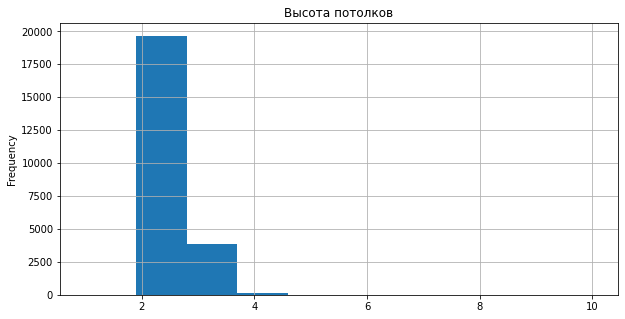

In [160]:
display(data['ceiling_height'].describe())
data['ceiling_height'].plot(kind='hist', bins=10, range=(1,10), grid=True, title='Высота потолков')
plt.show();

**Чаще всего встречаются квартиры с 2-3 метровым потолками**

count    23699.000000
mean         5.892358
std          4.885249
min          1.000000
25%          2.000000
50%          4.000000
75%          8.000000
max         33.000000
Name: floor, dtype: float64

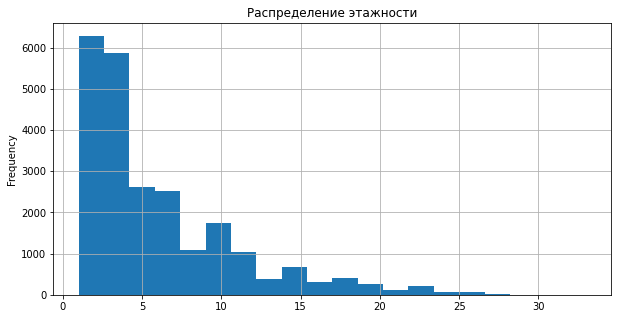

In [161]:
display(data['floor'].describe())
data['floor'].plot(kind='hist', bins=20,grid=True, title='Распределение этажности')
plt.show();

**В данных существенно преобладают квартиры на расположенные на 2-4 этажах**





count      23699
unique         3
top       Другой
freq       17441
Name: floor_type, dtype: object

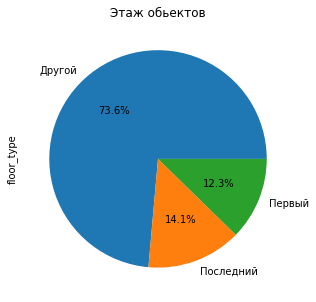

In [162]:
display(data['floor_type'].describe())
data['floor_type'].value_counts().plot(kind='pie', autopct='%1.1f%%', title='Этаж обьектов')
plt.show();

**Данная диаграмма показывает, что в процентном соотношении квартир, расп. на последних этажах в данных предcтавлено незначительно больше**

count    23699.000000
mean        10.667750
std          6.585961
min          1.000000
25%          5.000000
50%          9.000000
75%         16.000000
max         60.000000
Name: floors_total, dtype: float64

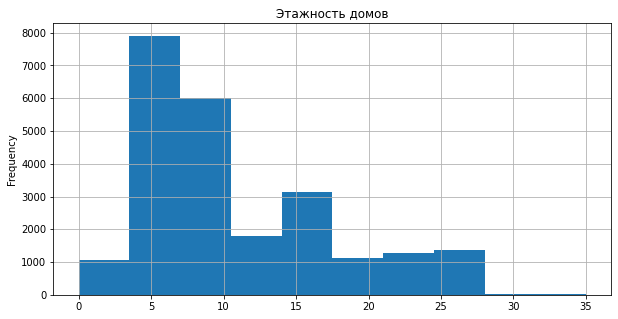

In [163]:
display(data['floors_total'].describe())
data['floors_total'].plot(kind='hist', bins=10,range=(0,35),grid=True, title='Этажность домов')
plt.show();

**В данных преобладают 5-6 этажные дома**

count    23699.000000
mean        13.908899
std          7.563081
min          0.000000
25%         11.000000
50%         13.000000
75%         15.000000
max         66.000000
Name: cityCenters_nearest, dtype: float64

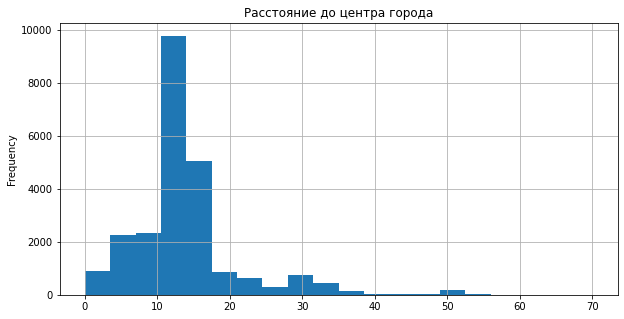

In [164]:
display(data['cityCenters_nearest'].describe())
data['cityCenters_nearest'].plot(kind='hist', bins=20, range=(0,70), grid=True, title='Расстояние до центра города')
plt.show();

**Большинство квартир находятся в 10-15 км от центра города.**

count    23699.000000
mean     28310.148023
std      11090.330161
min          0.000000
25%      21183.000000
50%      26726.000000
75%      34327.000000
max      84869.000000
Name: airports_nearest, dtype: float64

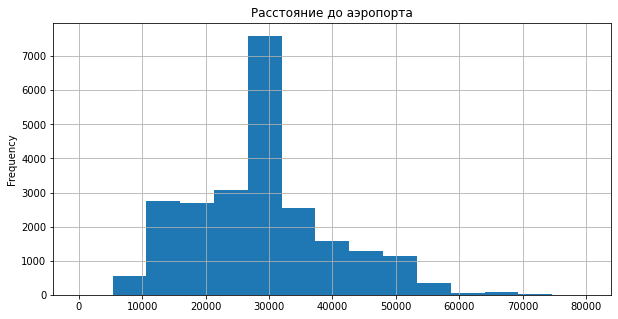

In [165]:
display(data['airports_nearest'].describe())
data['airports_nearest'].plot(kind='hist', bins=15, range=(0,80000), grid=True, title='Расстояние до аэропорта')
plt.show();

**Большинство квартир находятся в 25-30 км от аэропорта.**

count    8079.000000
mean      490.804555
std       342.317995
min         1.000000
25%       288.000000
50%       455.000000
75%       612.000000
max      3190.000000
Name: parks_nearest, dtype: float64

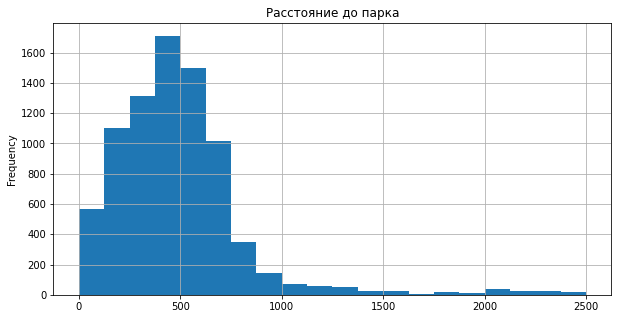

In [166]:
display(data['parks_nearest'].describe())
data['parks_nearest'].plot(kind='hist', bins=20,range=(0,2500), grid=True, title='Расстояние до парка')
plt.show();

**Большинство квартир, в которых указана удаленность от парка, располагаются в 400-500 метрах от парков. Причиной такого большого кол-во пропусков может быть как нахождение обьекта за городом, окруженным парками, так и банальная неосведомленность авторов, так и технический сбой при сборе данных**

count    23699.000000
mean         3.569307
std          1.789082
min          1.000000
25%          2.000000
50%          4.000000
75%          5.000000
max          7.000000
Name: day, dtype: float64

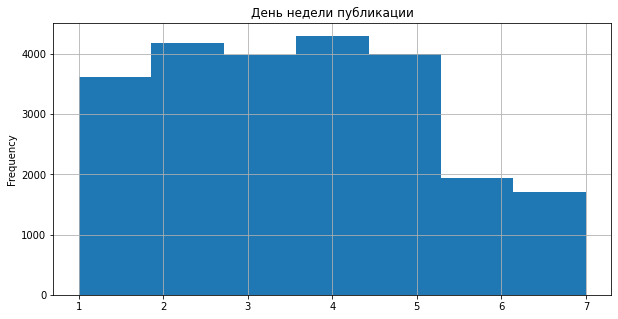

In [167]:
display(data['day'].describe())
data['day'].plot(kind='hist',bins=7,range=(1,7), grid=True, title='День недели публикации')
plt.show();

**Чаще всего обьявления публиковались по будним дням. Наибольшее кол-во по ВТ и ЧТ.**

count    23699.000000
mean         6.400101
std          3.491561
min          1.000000
25%          3.000000
50%          6.000000
75%         10.000000
max         12.000000
Name: month, dtype: float64

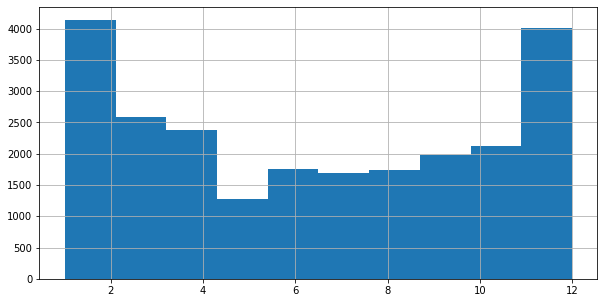

In [168]:
display(data['month'].describe())
data['month'].hist()
plt.show();

**Пик публикаций происходит в начале и конце года. Похоже люди и правда любят подводить итоги года**

count    23699.000000
mean       169.360226
std        206.535633
min          1.000000
25%         45.000000
50%         95.000000
75%        199.000000
max       1580.000000
Name: days_exposition, dtype: float64

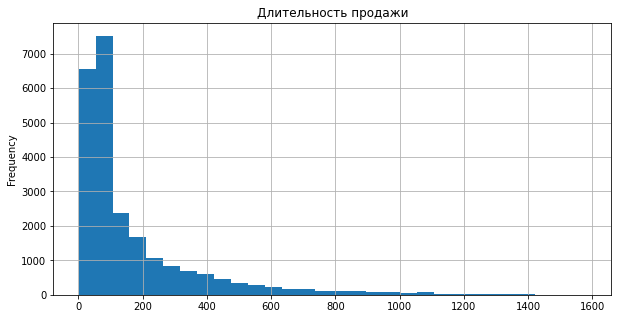

In [169]:
display(data['days_exposition'].describe())
data['days_exposition'].plot(kind='hist',bins=30,range=(1,1580), grid=True, title='Длительность продажи')
plt.show();

**В основном обьявления были актуальны на протяжении 100 дней. Можно предположить, что большинство обьектов продавались в течение 3 месяцев. Об этом нам говорит график и медиана в описании данных. Средний показатель больше в основном из-за немногочисленных обьявлений, которые по каким-то причинам были актуальны на протяжении более 1000 дней**


*   Быстрая продажа: меньше месяца(первый квартиль)
*   Долгая продажа: дольше 200 дней(6 мес.\ третий квартиль)





> *Какие факторы больше всего влияют на общую (полную) стоимость объекта? Изучите, зависит ли цена от: общей площади; жилой площади; площади кухни; количества комнат; этажа, на котором расположена квартира (первый, последний, другой); даты размещения (день недели, месяц, год).

>Постройте графики, которые покажут зависимость цены от указанных выше параметров. 
Для подготовки данных перед визуализацией вы можете использовать сводные таблицы*







cityCenters_nearest   -0.190334
ponds_nearest         -0.084809
year                  -0.043089
studio                -0.025362
parks_nearest         -0.016414
airports_nearest      -0.012134
open_plan             -0.008802
floors_total          -0.007003
day                    0.001550
month                  0.002779
balcony                0.008559
floor                  0.026576
is_apartment           0.026958
days_exposition        0.065469
total_images           0.104473
ponds_around3000       0.135001
parks_around3000       0.197840
ceiling_height         0.273636
rooms                  0.365209
kitchen_area           0.440316
living_area            0.540659
total_area             0.653675
meter_price            0.736499
last_price             1.000000
Name: last_price, dtype: float64


<AxesSubplot:>

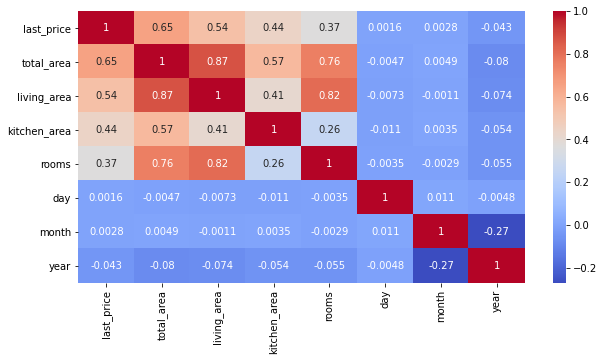

In [170]:
import seaborn as sns
print(data.corr()['last_price'].sort_values())
corr = data[['last_price','total_area', 'living_area', 'kitchen_area', 'rooms', 'day', 'month', 'year']].corr() 
sns.heatmap(corr, cmap='coolwarm', annot=True)

**Наибольшее влияение на формирование цены из Рассматриваемых факторов оказывает: общая площадь. То же подтверждается и вызовом метода .corr(). У living_area и total_area, согласно коэфффициенту корелляции Пирсона, наблюдается сильно положительная связь с стоимостью обьекта.**





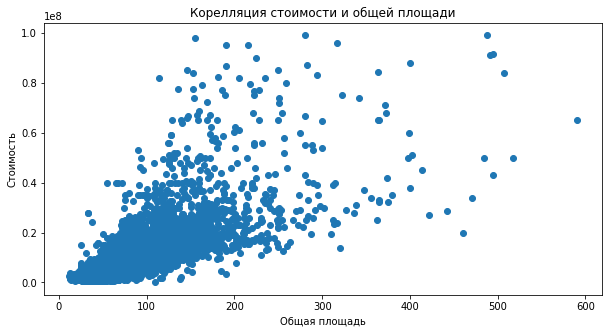

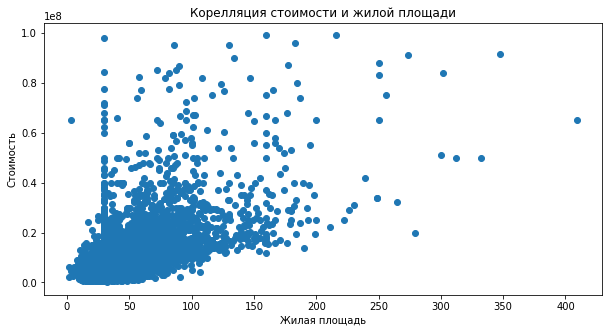

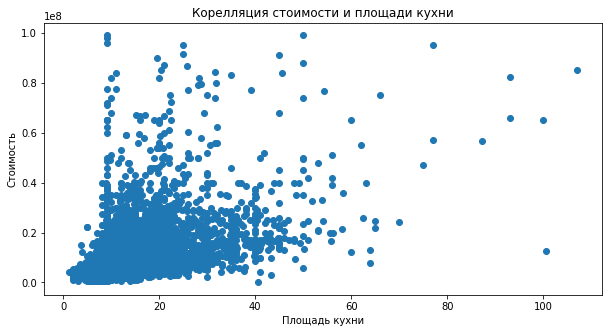

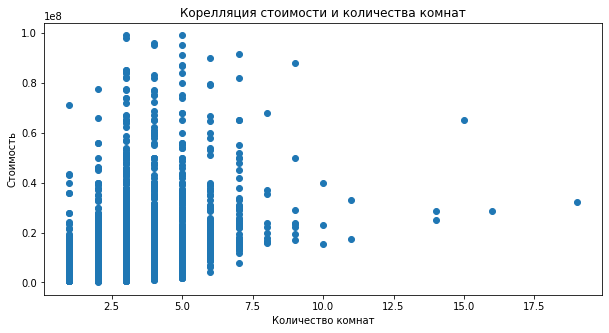

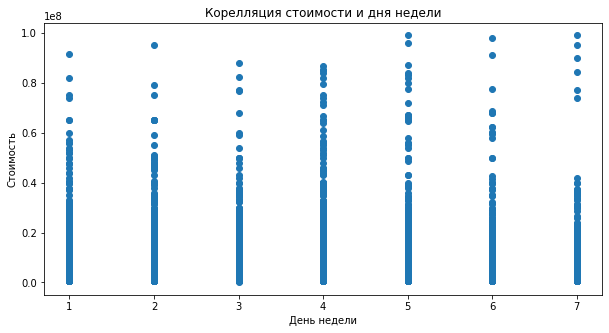

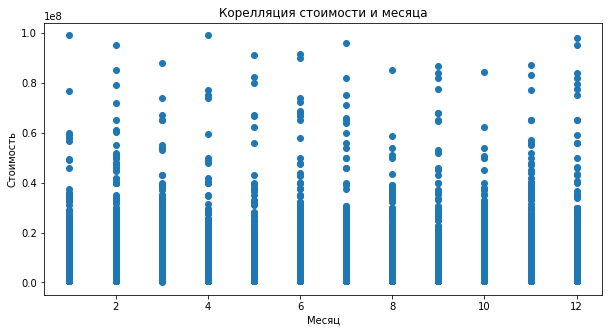

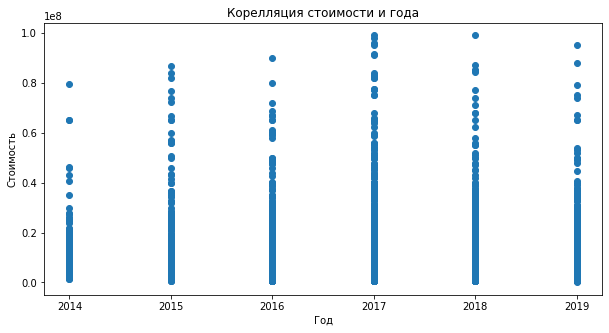

In [171]:
depend = ['total_area', 'living_area', 'kitchen_area', 'rooms', 'day', 'month', 'year'];
corr_ta = data.query('last_price <= 100000000') # убираем выбросы к которым так чувствительна корелляция Пирсона
#data.plot(y='last_price', x=data[depend], kind='scatter', figsize=(10,5))
#plt.scatter(corr_ta['last_price'], corr_ta['total_area'])
plt.rcParams["figure.figsize"] = (10,5)
for col in depend:
    #data.plot(y='last_price', x=col, kind='scatter', figsize=(10,5))
    plt.scatter(y=corr_ta['last_price'], x=corr_ta[col])
    if 'living_area' in col:
        plt.xlabel('Жилая площадь');
        plt.title('Корелляция стоимости и жилой площади');
    elif 'total_area' in col:
            plt.xlabel('Общая площадь');
            plt.title('Корелляция стоимости и общей площади');
    elif 'kitchen_area' in col:
            plt.xlabel('Площадь кухни');
            plt.title('Корелляция стоимости и площади кухни');
    elif 'rooms' in col:
            plt.xlabel('Количество комнат');
            plt.title('Корелляция стоимости и количества комнат');
    elif 'day' in col:
            plt.xlabel('День недели');
            plt.title('Корелляция стоимости и дня недели');
    elif 'month' in col:
            plt.xlabel('Месяц');
            plt.title('Корелляция стоимости и месяца');
    elif 'year' in col:
            plt.xlabel('Год');
            plt.title('Корелляция стоимости и года');
    plt.ylabel('Стоимость');
    plt.show();

**Можно заметить, что для парамеров total_area, living_area, kitchen_area наблюдается сильно положительная корелляция с увеличением стоимости в виду большого сосредоточения данных вдоль оси. Другие числовые параметры зависимости не имеют**

**Аномалии обьясняются замещением в living_area, kitchen_area большого числа пропусков значений медианными значениями.**

                 mean      count          %
           last_price last_price           
floor_type                                 
Другой        6676061      17441  73.593823
Первый        4803560       2917  12.308536
Последний     7356776       3341  14.097641


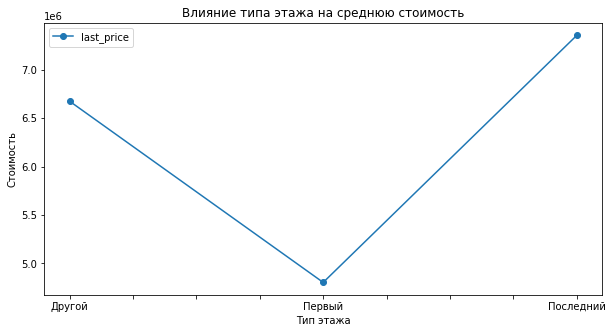

In [172]:
floor_type_corr = data.pivot_table(index = 'floor_type', values = ['last_price'], aggfunc = ['mean', 'count']).astype('int64')
floor_type_corr['%'] = floor_type_corr['count'] / floor_type_corr['count'].sum()*100 # считаем процентное соотношение
print(floor_type_corr)
floor_type_corr.plot(style='o-',y='mean', title='Влияние типа этажа на среднюю стоимость')
plt.ylabel('Стоимость')
plt.xlabel('Тип этажа')
plt.show()

**Понятно, как и ранее на диаграмме, что в обьявления преобладает разная этажность, но средняя цена на эти квартиры ниже, чем на обьявления с обьектами расположенными на последних этажа. Дешевле всего стоят квартиры на первом этаже.**

,median,count,%
,last_price,last_price,
day,,,
1,4650000,3612,15.241149
2,4730000,4183,17.650534
3,4700000,3974,16.768640
4,4650000,4295,18.123128
5,4585000,4000,16.878349
6,4555000,1936,8.169121
7,4550000,1699,7.169079


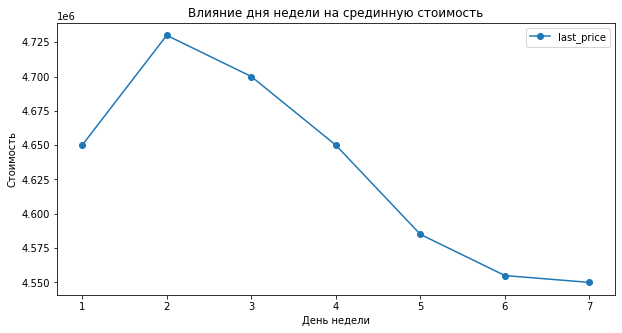

In [173]:
day_corr = data.pivot_table(index = ['day'], values = ['last_price'],
                               aggfunc = ['median', 'count']).astype('int64')
day_corr['%'] = day_corr['count'] / day_corr['count'].sum()*100 # считаем процентное соотношение
display(day_corr)

day_corr.plot(style='o-',y='median', title='Влияние дня недели на срединную стоимость')
plt.ylabel('Стоимость')
plt.xlabel('День недели')
plt.show()

**День недели публикации не сильно влияет на среднюю стоимость объекта. Однако в начале недели наблюдается рост стоимости**

,median,count,%
,last_price,last_price,
month,,,
1,4600000,1500,6.329381
2,4650000,2640,11.139711
3,4650000,2587,10.916072
4,4800000,2379,10.038398
5,4515000,1274,5.375754
6,4400000,1760,7.426474
7,4650000,1695,7.152201
8,4570000,1744,7.358960


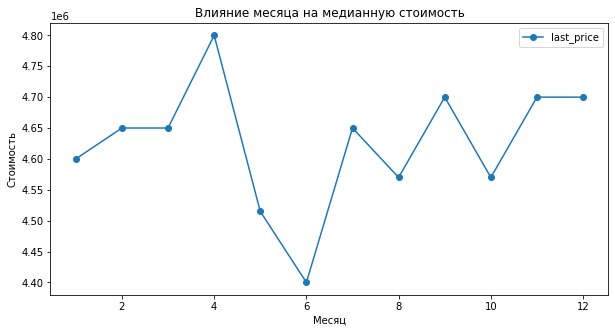

In [174]:
month_corr = data.pivot_table(index = ['month'], values = ['last_price'],
                               aggfunc = ['median', 'count']).astype('int64')
month_corr['%'] = month_corr['count'] / month_corr['count'].sum()*100 # считаем процентное соотношение
display(month_corr)

month_corr.plot(style='o-',y='median', title='Влияние месяца на медианную стоимость')
plt.ylabel('Стоимость')
plt.xlabel('Месяц')
plt.show()

**Средняя стоимость обьекта не зависит от месяца публикации. Больше всего квартир продано в феврале-марте. Меньше всего мае.**

,median,count,%
,last_price,last_price,
year,,,
2014,7700000,137,0.578083
2015,5350000,1191,5.025529
2016,4550000,2783,11.743112
2017,4500000,8190,34.558420
2018,4550000,8519,35.946664
2019,5050000,2879,12.148192


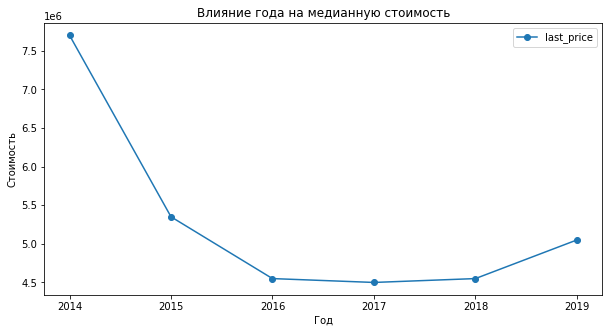

In [175]:
year_corr = data.pivot_table(index = 'year', values = ['last_price'],
                               aggfunc = ['median', 'count']).astype('int64')
year_corr['%'] = year_corr['count'] / year_corr['count'].sum()*100 # считаем процентное соотношение
display(year_corr)

year_corr.plot(style='o-',y='median', title='Влияние года на медианную стоимость')
plt.ylabel('Стоимость')
plt.xlabel('Год')
plt.show()

**Нет зависимости стоимости обьекта от года публикации**

**2014 в рассчет не берем т.к. данных слишком мало.**

> Посчитайте среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений. Выделите населённые пункты с самой высокой и низкой стоимостью квадратного метра. Эти данные можно найти по имени в столбце locality_name.






In [176]:
local_meter_price = data.pivot_table(index='locality_name', values='meter_price', aggfunc=['median', 'count'])
local_meter_price.columns = ['Средняя стоимость метра','Количество объявлений']
local_meter_price_top = local_meter_price.sort_values(by='Количество объявлений', ascending=False).head(10)
print(local_meter_price_top.sort_values(by='Средняя стоимость метра', ascending=False))

                   Средняя стоимость метра  Количество объявлений
locality_name                                                    
Санкт-Петербург                 104761.900                  15721
Пушкин                          100000.000                    369
деревня Кудрово                  91860.470                    299
посёлок Парголово                91642.860                    327
посёлок Мурино                   85878.465                    556
посёлок Шушары                   76876.175                    440
Колпино                          74723.745                    338
Гатчина                          67796.610                    307
Всеволожск                       65789.470                    398
Выборг                           58158.320                    237


**Самая высокая стоимость квадратного метра, как и ожидалось, в Петербурге. Минимальная стоимость наблюдается в Выборге.**



> Ранее вы посчитали расстояние до центра в километрах. Теперь выделите квартиры в Санкт-Петербурге с помощью столбца locality_name и вычислите среднюю цену каждого километра. Опишите, как стоимость объектов зависит от расстояния до центра города.



cityCenters_nearest
0.0              inf
1.0     2.120672e+07
2.0     8.894160e+06
3.0     3.708860e+06
4.0     3.326070e+06
5.0     2.899824e+06
6.0     2.556403e+06
7.0     2.110736e+06
8.0     1.244715e+06
9.0     7.722954e+05
10.0    6.504119e+05
11.0    5.682559e+05
12.0    4.857121e+05
13.0    4.976400e+05
14.0    4.020787e+05
15.0    3.923168e+05
16.0    3.358207e+05
17.0    3.113173e+05
18.0    2.828517e+05
19.0    2.651408e+05
20.0    2.975732e+05
21.0    2.615938e+05
22.0    2.461602e+05
23.0    2.167555e+05
24.0    1.606012e+05
25.0    1.621136e+05
26.0    1.528082e+05
27.0    3.074074e+05
28.0    1.795153e+05
29.0    1.460920e+05
Name: price_per_km, dtype: float64


/tmp/ipykernel_31/2710382486.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spb_data['price_per_km'] = spb_data['last_price'] / spb_data['cityCenters_nearest']


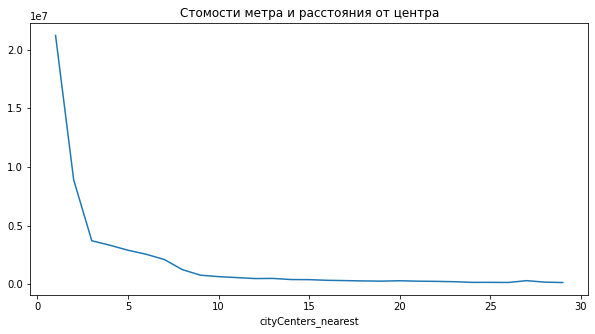

In [177]:
spb_data = data.query('locality_name == "Санкт-Петербург"')
# Посчитаем цену километра для каждого обьявления
spb_data['price_per_km'] = spb_data['last_price'] / spb_data['cityCenters_nearest']

# Так как значения в столбце ['cityCenters_nearest'] повторяются - может помчитать среднюю для каждого километра
price_per_km = spb_data.groupby('cityCenters_nearest')['price_per_km'].mean()
print(price_per_km)
price_per_km.plot(x='cityCenters_nearest', y='price_per_km', style='-', title = 'Стомости метра и расстояния от центра');
plt.show()

**Результат предсказуем: чем дальше от центра города тем дешевле**

### Общий вывод

Шаг 5. Напишите общий вывод

*  В ходе анализа данных было выявлено, что больше других распространены квартиры с общей площадью от 30 до 50 квадратных метров. Жилая площадь из них это 15-30 квадратных метров. Кухня занимает от 5 до 10 квадратных метров. Чаще всего встречаются 1-3 комнатные квартиры с 2-3 метровым потолками расположенные на 2-4 этажах в 5-6 этажных домах. При этом квартир, расположенных на верхних этажах больше, чем на первых. Как правило, они находятся в 10-15 км от центра города, 25-30 км от аэропорта и в 400-500 метрах от близжайшего парка, если таковой имеется.

*  Средняя стоимость представленных квартир около 4 млн. рублей. Наибольщее влияение на формирование цены из рассматриваемых факторов оказывает: стоимость квадратного метра, общая и жилая площадь в квартире. Дороже всего квартиры на последнем этаже. Дешевле - на первом. Дата публикации влияет на цену объекта.
Самая высокая стоимость квадратного метра Петербурге. Минимальная стоимость наблюдается в Выборге.

*  Чаще всего обьявления публиковались по будним дням. Наибольшее кол-во по ВТ и ЧТ. Пик публикаций происходит в начале и конце года. Большинство обьектов продавались в течение 3 месяцев. Быстрая продажа происходит течении 30 дней, медленной продажей будем считать объявление, сроком в 6 месяцев и выше.
